In [84]:
!pip install git+https://github.com/openai/CLIP.git
!pip install matplotlib pandas scikit-learn tqdm


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-6_o4_8wx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-6_o4_8wx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [85]:
import os
from PIL import Image
import numpy as np
import torch
import clip
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


In [86]:
from google.colab import drive
drive.mount('/content/drive')

# Define your base path
base_dir = "/content/drive/MyDrive/CS6365/outputs"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
models = [
    "DALL-E",
    "Firefly",
    "Midjourney",
    "stable_diffusion",
    "kandinsky"
]

#Define file prefixes for each model to match filenames
file_patterns = {
    "DALL-E": "DALL-E",
    "Firefly": "Firefly",
    "Midjourney": "Midjourney",
    "stable_diffusion": "sd_",
    "kandinsky": "kandinsky"
}

#Create a list of all files in outputs
all_images = []

for model in models:
    folder = os.path.join(base_dir, model)
    for file in os.listdir(folder):
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            all_images.append({
                "filepath": os.path.join(folder, file),
                "model": model,
                "filename": file
            })

print(f"Found {len(all_images)} images.")


Found 300 images.


In [88]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device)


In [89]:
#Initialize lists to store image embeddings, model labels, and filenames
embeddings = []
labels = []
filenames = []
#Iterate through each image in outputs
for img_data in tqdm(all_images):
    try:
      #Open the image and convert it to RGB
      image = Image.open(img_data["filepath"]).convert("RGB")
      image_input = preprocess(image).unsqueeze(0).to(device)

      with torch.no_grad():
        #Encode the image to obtain its CLIP embeddings
        image_features = clip_model.encode_image(image_input).cpu().numpy()

      #Flattent and append the image
      embeddings.append(image_features.flatten())
      labels.append(img_data["model"])
      filenames.append(img_data["filename"])
    except Exception as e:
      print(f"Error processing {img_data['filepath']}: {e}")
#Save as a dataframe
df = pd.DataFrame(embeddings)
df["model"] = labels
df["filename"] = filenames

print(df.shape)


100%|██████████| 300/300 [00:16<00:00, 18.53it/s]

(300, 514)


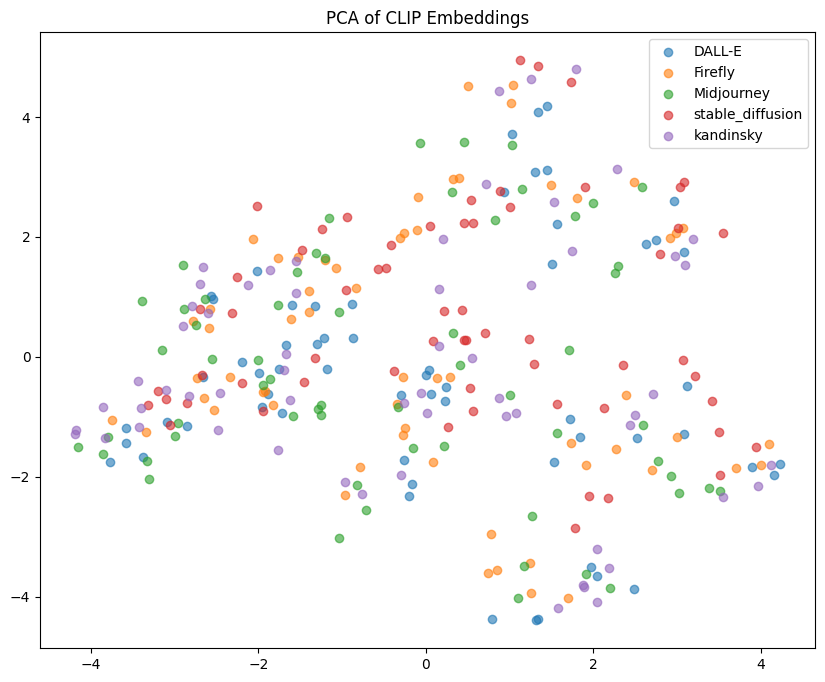

In [90]:
pca = PCA(n_components=2)
coords = pca.fit_transform(df.iloc[:, :-2])

plt.figure(figsize=(10,8))
for model in models:
    idx = df["model"] == model
    plt.scatter(coords[idx,0], coords[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title("PCA of CLIP Embeddings")
plt.show()


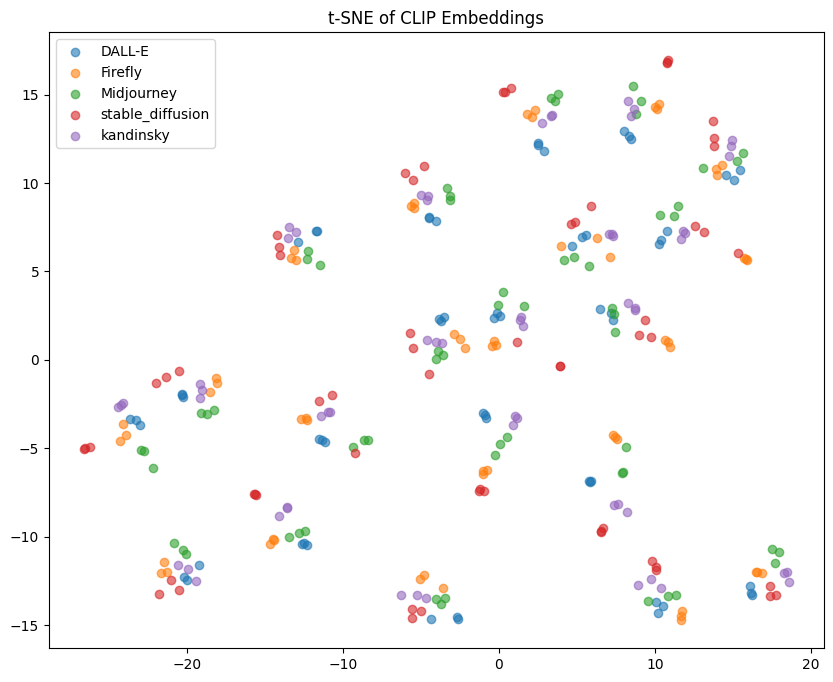

In [91]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords_tsne = tsne.fit_transform(df.iloc[:, :-2])

plt.figure(figsize=(10,8))
for model in models:
    idx = df["model"] == model
    plt.scatter(coords_tsne[idx,0], coords_tsne[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title("t-SNE of CLIP Embeddings")
plt.show()


In [92]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

#Identify the numeric embedding columns
embedding_cols = df.columns.difference(["model", "filename"])

#Group by model and compute mean embeddings
mean_embeddings = df.groupby("model")[embedding_cols].mean()

#Compute cosine similarities between mean embeddings
cos_sim = cosine_similarity(mean_embeddings.values)

#Create a DataFrame for readability
cos_sim_df = pd.DataFrame(
    cos_sim,
    index=mean_embeddings.index,
    columns=mean_embeddings.index
)

print(cos_sim_df)


model               DALL-E   Firefly  Midjourney  kandinsky  stable_diffusion
model                                                                        
DALL-E            1.000000  0.926642    0.960333   0.957665          0.930079
Firefly           0.926642  1.000000    0.955414   0.971290          0.958700
Midjourney        0.960333  0.955414    0.999999   0.978275          0.942862
kandinsky         0.957665  0.971290    0.978275   1.000000          0.966327
stable_diffusion  0.930079  0.958700    0.942862   0.966327          1.000000


In [93]:
from itertools import combinations
import numpy as np

print("Pairwise model similarities:")

for m1, m2 in combinations(models, 2):
    idx1 = df["model"] == m1
    idx2 = df["model"] == m2

    embeds1 = df.loc[idx1, embedding_cols].values
    embeds2 = df.loc[idx2, embedding_cols].values

    #Compute pairwise cosine similarities
    distances = cosine_similarity(embeds1, embeds2)
    mean_sim = np.mean(distances)

    print(f"Average similarity between {m1} and {m2}: {mean_sim:.4f}")


Pairwise model similarities:
Average similarity between DALL-E and Firefly: 0.5546
Average similarity between DALL-E and Midjourney: 0.5793
Average similarity between DALL-E and stable_diffusion: 0.5426
Average similarity between DALL-E and kandinsky: 0.5849
Average similarity between Firefly and Midjourney: 0.5583
Average similarity between Firefly and stable_diffusion: 0.5412
Average similarity between Firefly and kandinsky: 0.5747
Average similarity between Midjourney and stable_diffusion: 0.5368
Average similarity between Midjourney and kandinsky: 0.5837
Average similarity between stable_diffusion and kandinsky: 0.5573


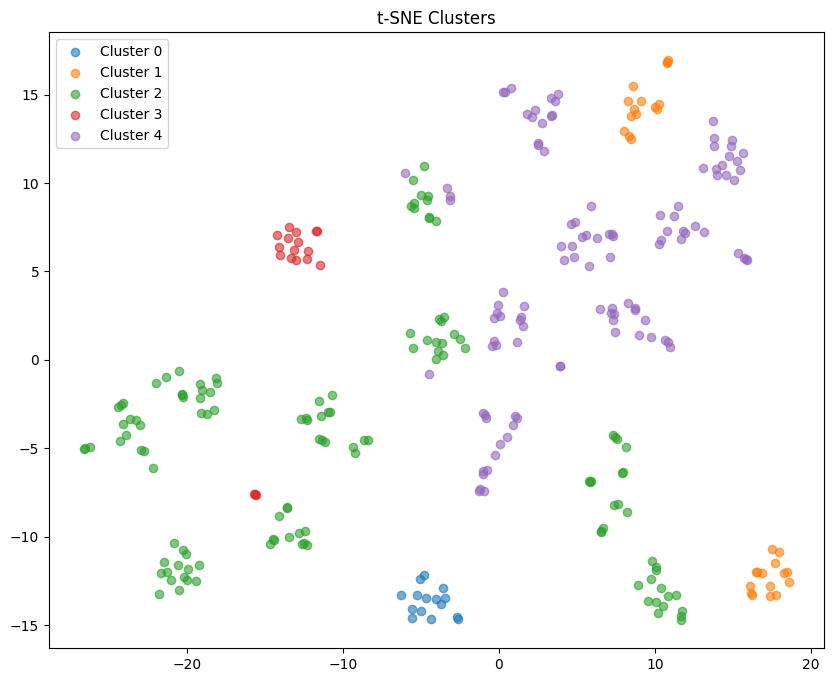

In [94]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5, random_state=42)
labels_cluster = kmeans.fit_predict(df.iloc[:, :-2])

df["cluster"] = labels_cluster

#Visualize clusters in t-SNE
plt.figure(figsize=(10,8))
for c in np.unique(labels_cluster):
    idx = df["cluster"] == c
    plt.scatter(coords_tsne[idx,0], coords_tsne[idx,1], label=f"Cluster {c}", alpha=0.6)
plt.legend()
plt.title("t-SNE Clusters")
plt.show()


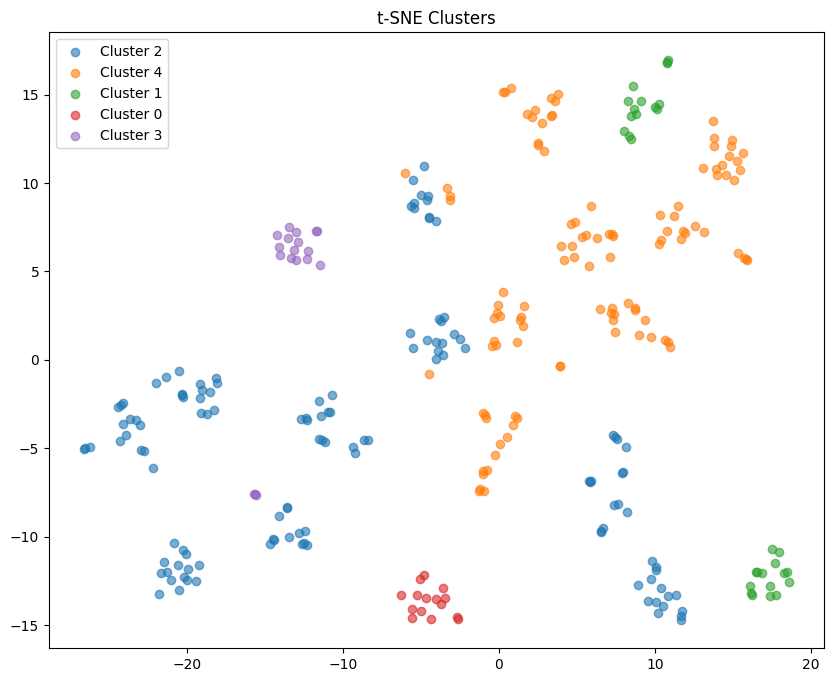

In [95]:
plt.figure(figsize=(10,8))
for c in df["cluster"].unique():
    idx = df["cluster"] == c
    plt.scatter(coords_tsne[idx,0], coords_tsne[idx,1], label=f"Cluster {c}", alpha=0.6)
plt.legend()
plt.title("t-SNE Clusters")
plt.show()


In [96]:
from sklearn.cluster import KMeans
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(df[embedding_cols])

#Count how many images per model fall into each cluster
cluster_summary = pd.crosstab(df["cluster"], df["model"])
print(cluster_summary)


model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             3        3           3          3                 3
1             6        6           6          6                 6
2            27       27          24         27                22
3             3        3           3          3                 6
4            21       21          24         21                23


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


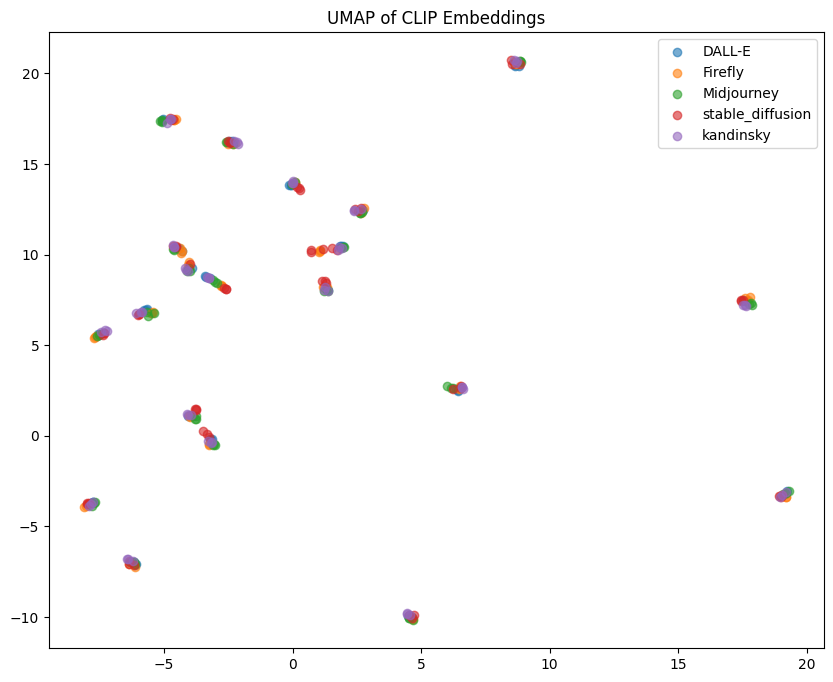

In [97]:
!pip install umap-learn

import umap

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)
coords_umap = reducer.fit_transform(df[embedding_cols])

plt.figure(figsize=(10,8))
for model in models:
    idx = df["model"] == model
    plt.scatter(coords_umap[idx,0], coords_umap[idx,1], label=model, alpha=0.6)
plt.legend()
plt.title("UMAP of CLIP Embeddings")
plt.show()


In [98]:
import re

def extract_prompt_id(row):
    filename = row["filename"]

    #Remove file extension
    name_part = filename.rsplit(".", 1)[0]

    # For formats like:
    #   DALL-E 0.0.png
    #   Firefly 0.0.png
    #   sd_0_0.png
    #   kandinsky_2_1_0_0.png

    #Find all numbers in name_part
    numbers = re.findall(r"\d+", name_part)

    if "sd_" in filename:
        #Stable Diffusion format: sd_0_0.png → 0_0
        #Take first digit group as prompt ID
        return int(numbers[0])
    elif "kandinsky" in filename:
        #Kandinsky format: kandinsky_2_1_0_0.png
        #The prompt ID is typically the 3rd number
        return int(numbers[2])
    else:
        #All other models like DALL-E, Firefly, Midjourney:
        #Take only the integer **before the dot**
        parts = name_part.split()
        last_part = parts[-1]
        prompt_id = int(last_part.split(".")[0])
        return prompt_id

df["prompt_id"] = df.apply(extract_prompt_id, axis=1)
print(df[["filename", "model", "prompt_id"]])


                  filename      model  prompt_id
0           DALL-E 0.0.png     DALL-E          0
1           DALL-E 0.1.png     DALL-E          0
2           DALL-E 0.2.png     DALL-E          0
3           DALL-E 1.0.png     DALL-E          1
4           DALL-E 2.0.png     DALL-E          2
..                     ...        ...        ...
295  kandinsky_2_1_8_1.png  kandinsky          8
296  kandinsky_2_1_8_2.png  kandinsky          8
297  kandinsky_2_1_9_0.png  kandinsky          9
298  kandinsky_2_1_9_1.png  kandinsky          9
299  kandinsky_2_1_9_2.png  kandinsky          9

[300 rows x 3 columns]


In [99]:
prompt_counts = df.groupby(["prompt_id", "model"]).size().unstack(fill_value=0)
print(prompt_counts)


model      DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
prompt_id                                                          
0               3        3           3          3                 3
1               3        3           3          3                 3
2               3        3           3          3                 3
3               3        3           3          3                 3
4               3        3           3          3                 3
5               3        3           3          3                 3
6               3        3           3          3                 3
7               3        3           3          3                 3
8               3        3           3          3                 3
9               3        3           3          3                 3
10              3        3           3          3                 3
11              3        3           3          3                 3
12              3        3           3          

In [100]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import combinations

prompt_similarities = []

for pid in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == pid]
    models_present = group["model"].unique()

    #Skip prompts that don't exist in at least 2 models
    if len(models_present) < 2:
        continue

    #Compute mean embedding for each model
    mean_embeddings = group.groupby("model")[embedding_cols].mean()

    #Pairwise comparisons
    for m1, m2 in combinations(models_present, 2):
        emb1 = mean_embeddings.loc[m1].values.reshape(1, -1)
        emb2 = mean_embeddings.loc[m2].values.reshape(1, -1)
        sim = cosine_similarity(emb1, emb2)[0,0]
        prompt_similarities.append({
            "prompt_id": pid,
            "model1": m1,
            "model2": m2,
            "similarity": sim
        })

prompt_sim_df = pd.DataFrame(prompt_similarities)
print(prompt_sim_df.head())


   prompt_id   model1            model2  similarity
0          0   DALL-E           Firefly    0.857436
1          0   DALL-E        Midjourney    0.862892
2          0   DALL-E  stable_diffusion    0.862778
3          0   DALL-E         kandinsky    0.907007
4          0  Firefly        Midjourney    0.882863


In [101]:
avg_sim = prompt_sim_df.groupby(["model1", "model2"])["similarity"].mean().reset_index()
print(avg_sim)


             model1            model2  similarity
0            DALL-E           Firefly    0.853031
1            DALL-E        Midjourney    0.885129
2            DALL-E         kandinsky    0.886584
3            DALL-E  stable_diffusion    0.815420
4           Firefly        Midjourney    0.858032
5           Firefly         kandinsky    0.869942
6           Firefly  stable_diffusion    0.832362
7        Midjourney         kandinsky    0.888418
8        Midjourney  stable_diffusion    0.819312
9  stable_diffusion         kandinsky    0.853606


In [102]:
lowest = prompt_sim_df.sort_values("similarity").head(10)
print("Prompts with least agreement across models:")
print(lowest)


Prompts with least agreement across models:
     prompt_id            model1            model2  similarity
85           8           Firefly  stable_diffusion    0.618624
189         18  stable_diffusion         kandinsky    0.619028
182         18            DALL-E  stable_diffusion    0.636971
40           4            DALL-E           Firefly    0.678467
120         12            DALL-E           Firefly    0.694365
186         18           Firefly         kandinsky    0.696401
82           8            DALL-E  stable_diffusion    0.705562
87           8        Midjourney  stable_diffusion    0.711380
44           4           Firefly        Midjourney    0.714959
159         15  stable_diffusion         kandinsky    0.718953


In [103]:
for pid in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == pid]
    models_present = group["model"].unique()

    if len(models_present) < 2:
        continue

    print(f"Prompt {pid}:")
    for model in models_present:
        sub = group[group["model"] == model]
        if len(sub) > 1:
            sim = cosine_similarity(sub[embedding_cols].values)
            upper = sim[np.triu_indices_from(sim, k=1)]
            avg_sim = upper.mean() if len(upper) else 1.0
            print(f"   Intra-similarity for {model}: {avg_sim:.3f}")
    print()


Prompt 0:
   Intra-similarity for DALL-E: 0.967
   Intra-similarity for Firefly: 0.914
   Intra-similarity for Midjourney: 0.917
   Intra-similarity for stable_diffusion: 0.794
   Intra-similarity for kandinsky: 0.938

Prompt 1:
   Intra-similarity for DALL-E: 0.942
   Intra-similarity for Firefly: 0.952
   Intra-similarity for Midjourney: 0.929
   Intra-similarity for stable_diffusion: 0.841
   Intra-similarity for kandinsky: 0.945

Prompt 2:
   Intra-similarity for DALL-E: 0.963
   Intra-similarity for Firefly: 0.906
   Intra-similarity for Midjourney: 0.945
   Intra-similarity for stable_diffusion: 0.744
   Intra-similarity for kandinsky: 0.954

Prompt 3:
   Intra-similarity for DALL-E: 0.964
   Intra-similarity for Firefly: 0.951
   Intra-similarity for Midjourney: 0.848
   Intra-similarity for stable_diffusion: 0.743
   Intra-similarity for kandinsky: 0.921

Prompt 4:
   Intra-similarity for DALL-E: 0.912
   Intra-similarity for Firefly: 0.897
   Intra-similarity for Midjourney: 0

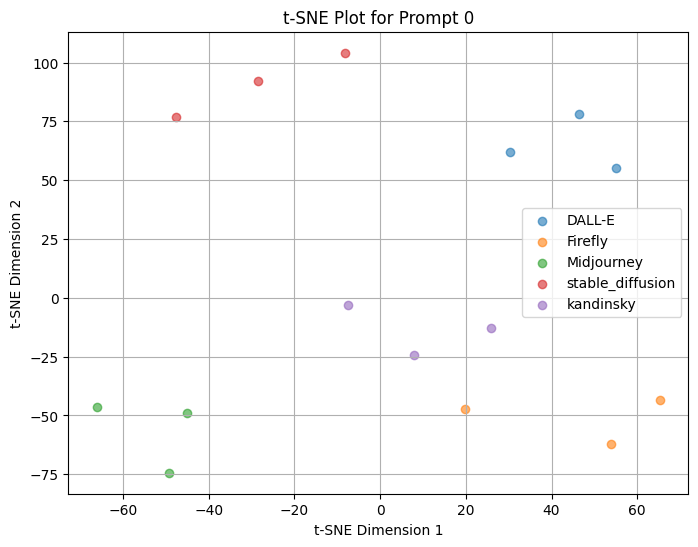

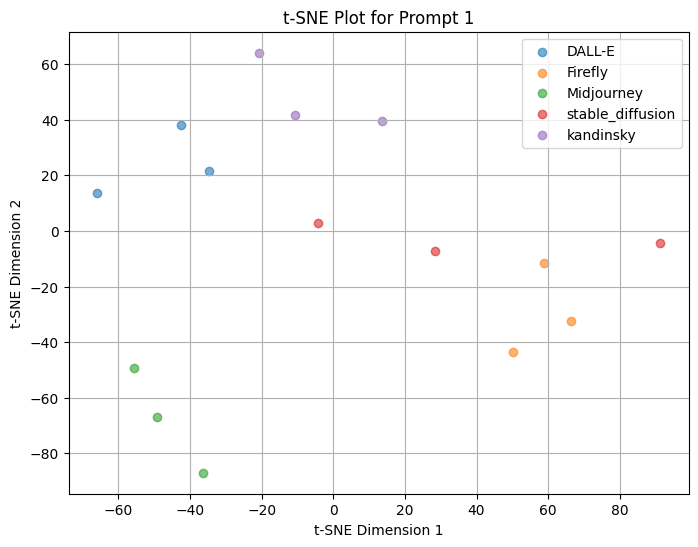

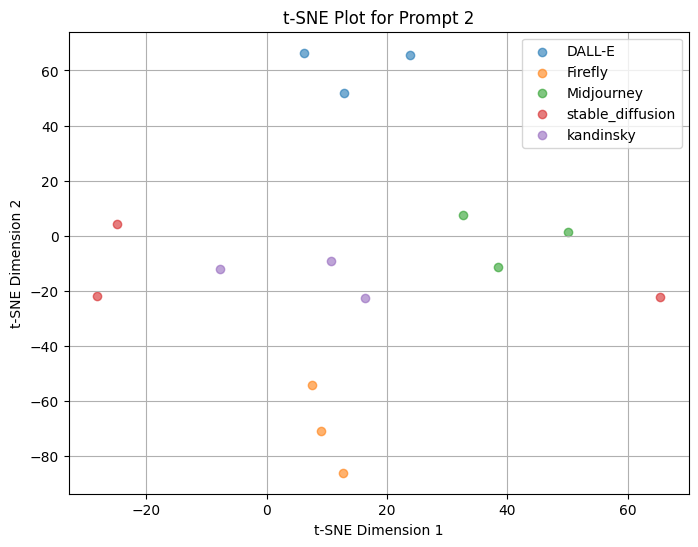

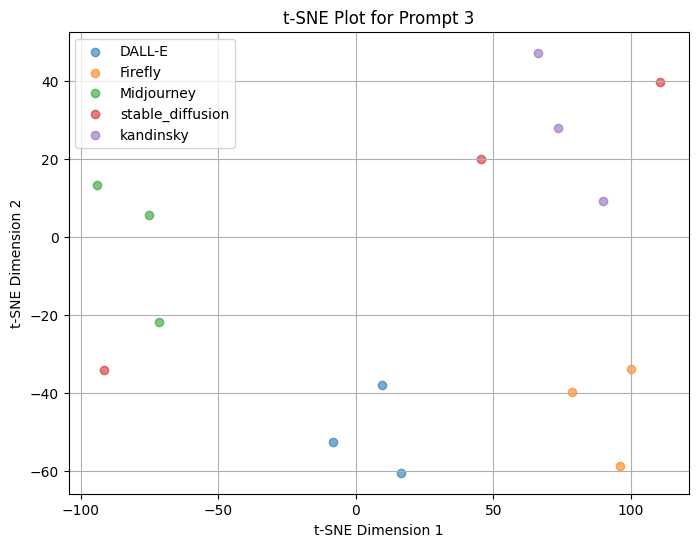

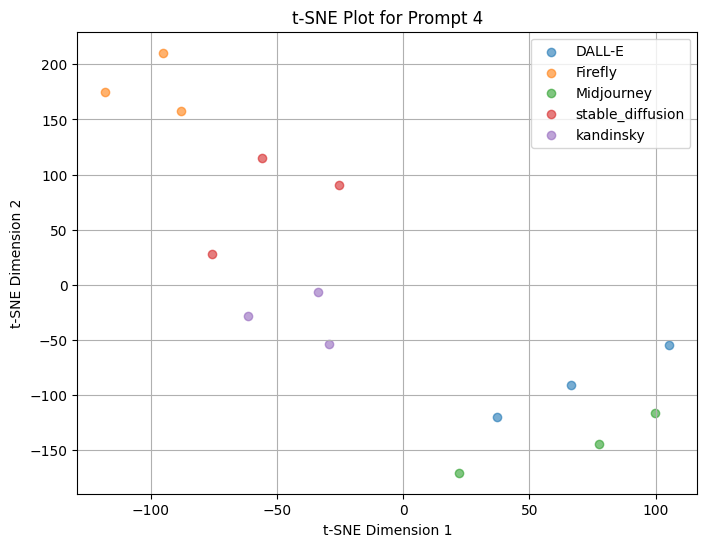

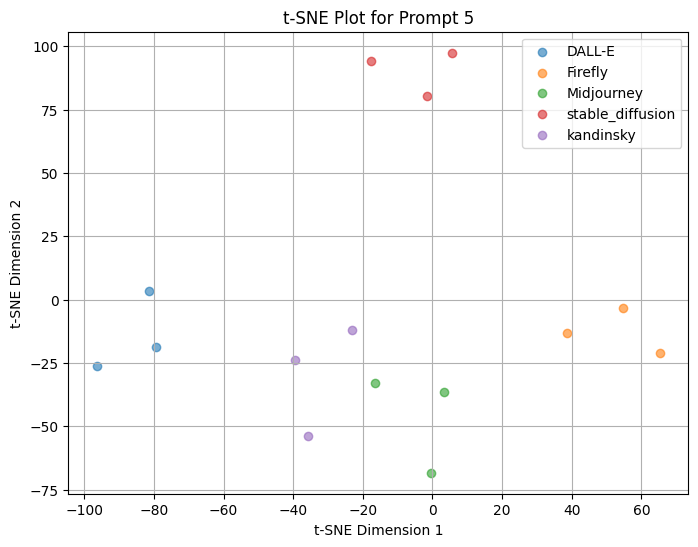

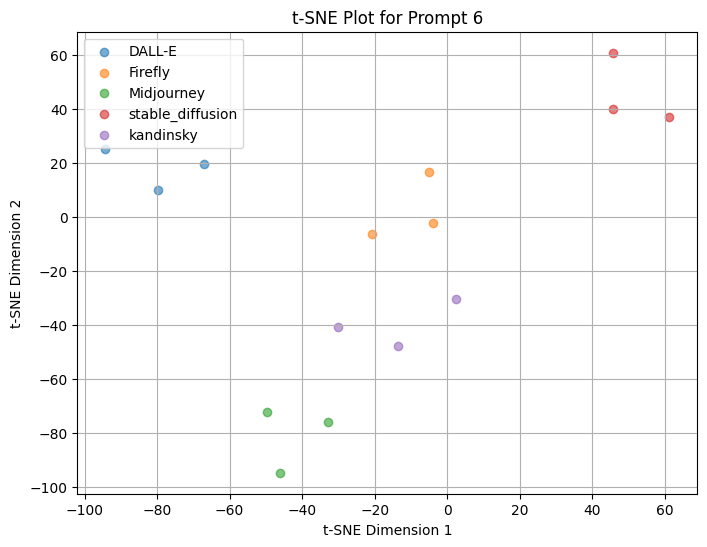

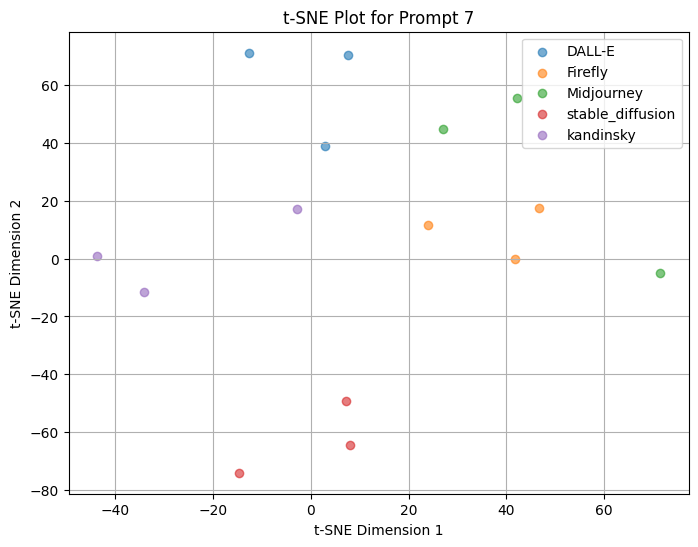

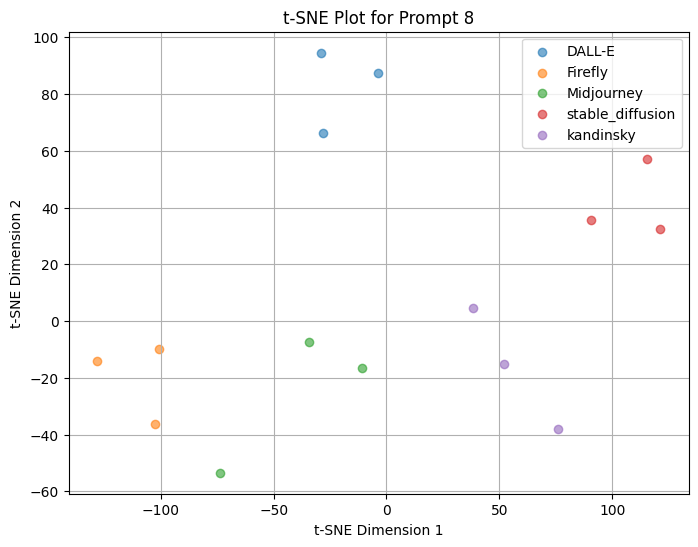

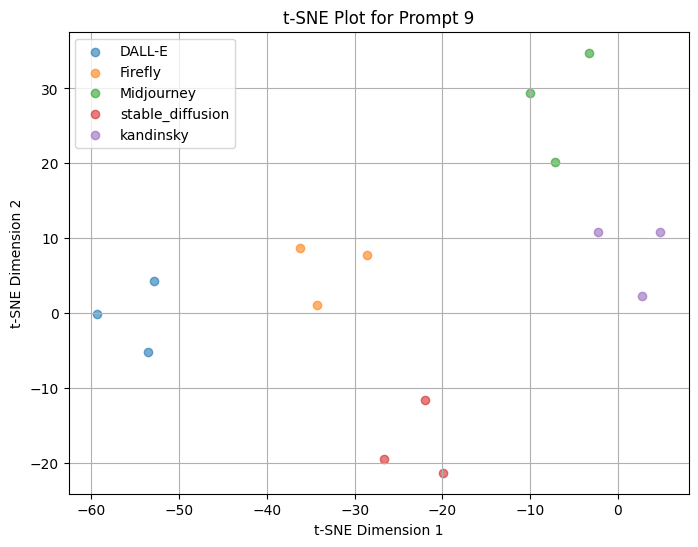

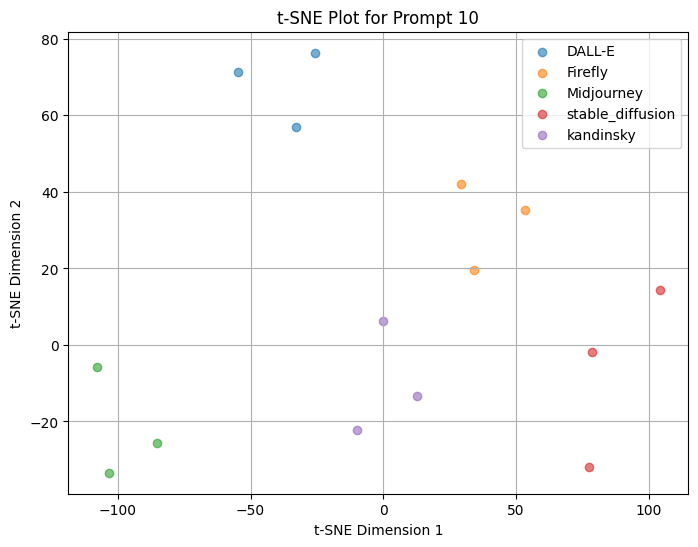

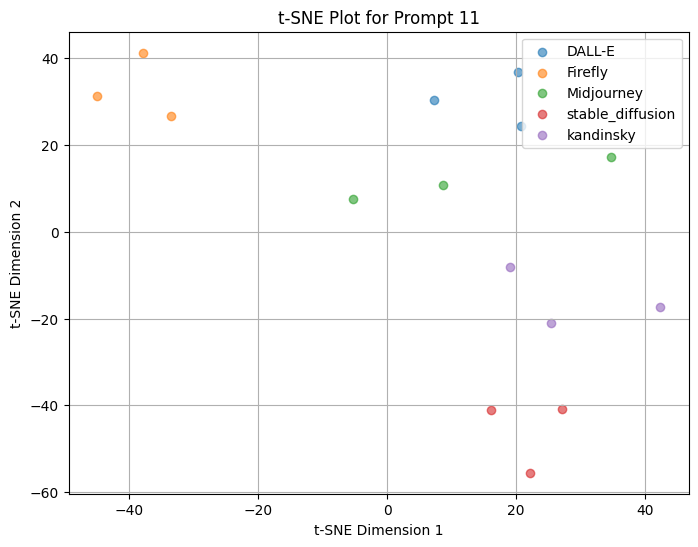

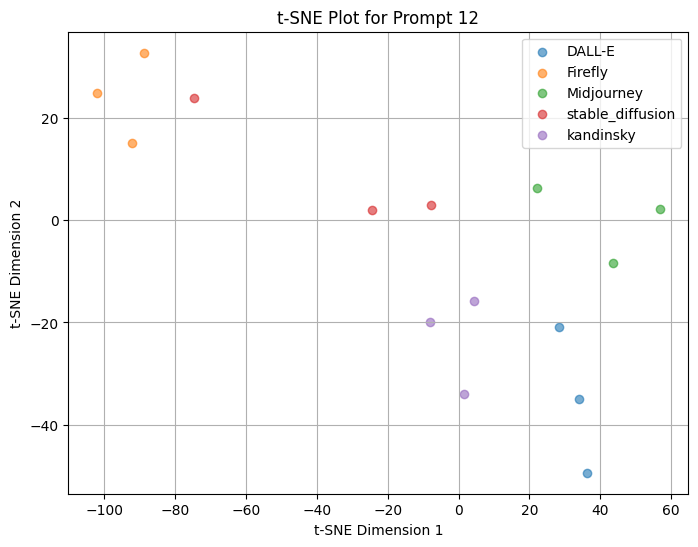

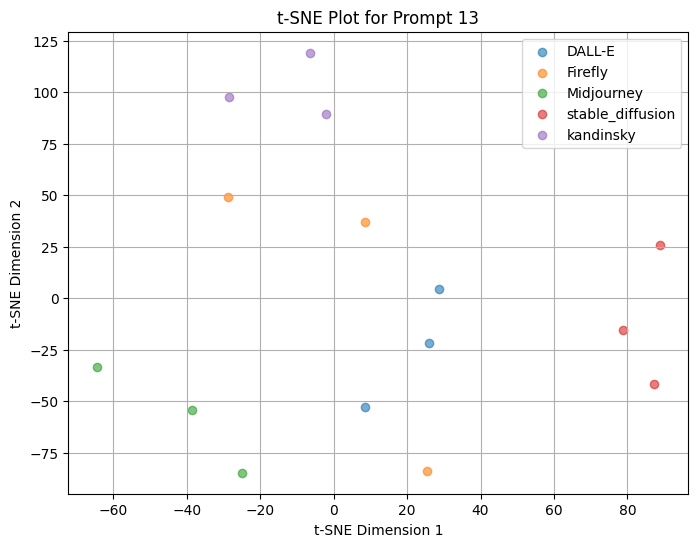

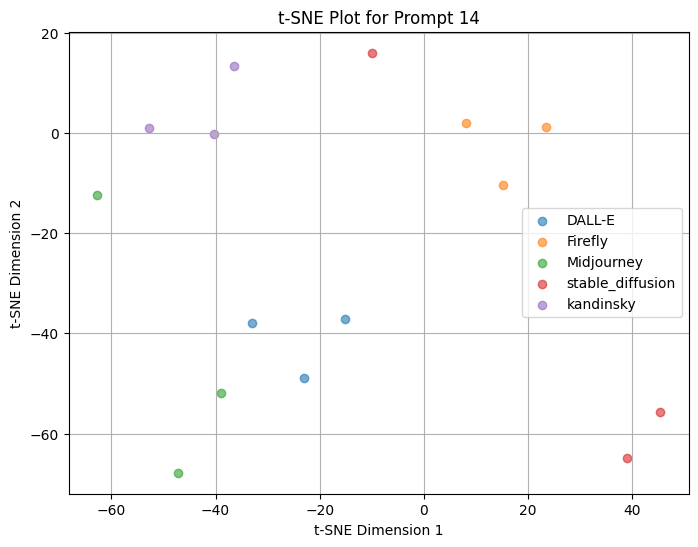

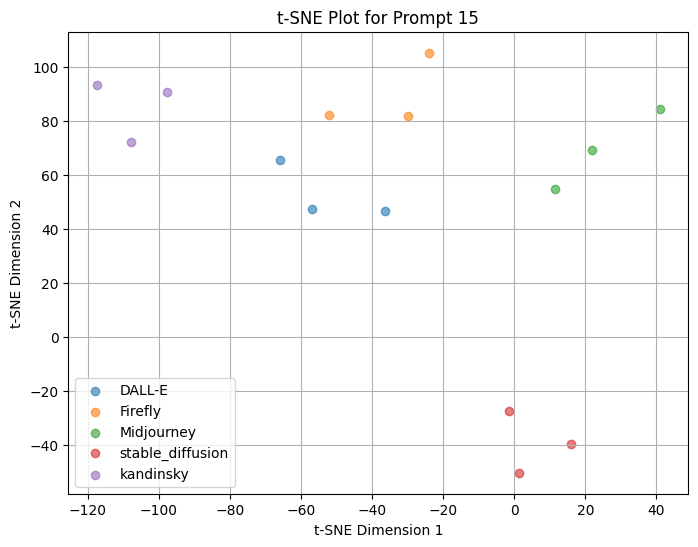

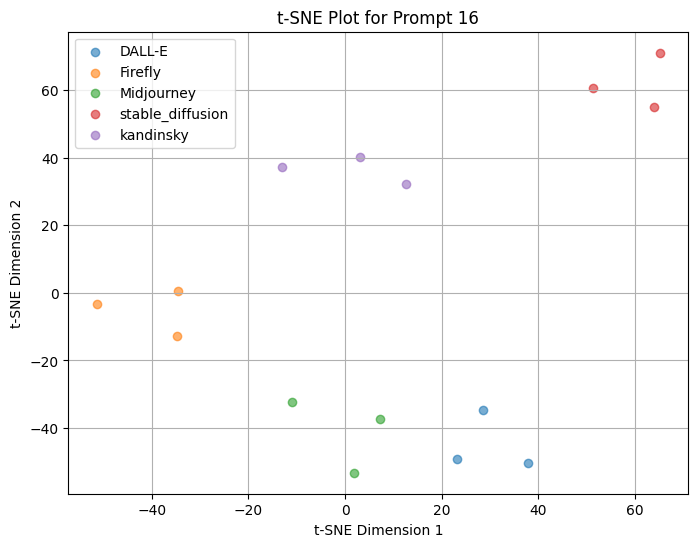

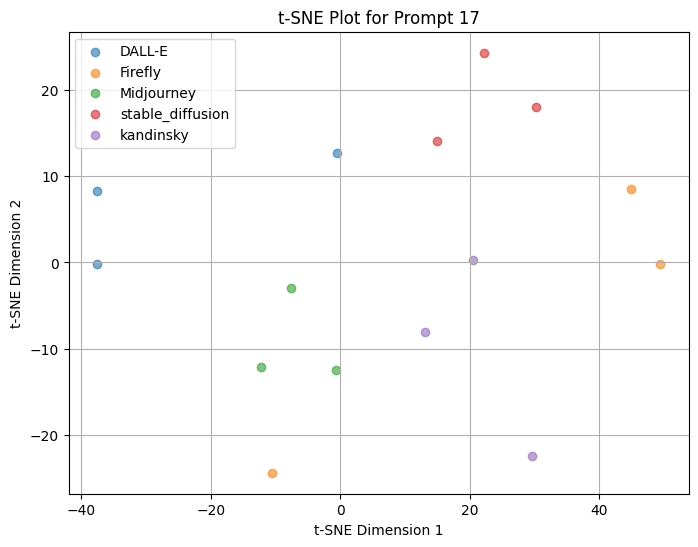

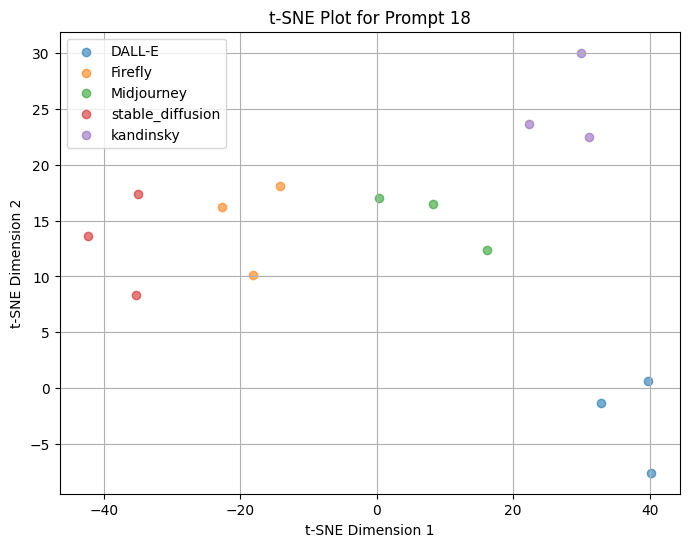

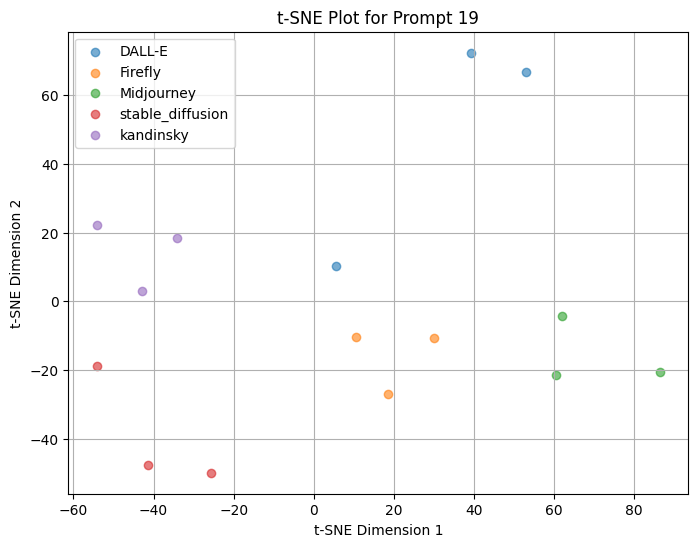

In [104]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

unique_prompts = df["prompt_id"].unique()

for prompt_id in sorted(unique_prompts):
    group = df[df["prompt_id"] == prompt_id]

    #Run t-SNE on embeddings for this prompt
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    coords = tsne.fit_transform(group[embedding_cols])

    #Plot
    plt.figure(figsize=(8,6))
    for model in group["model"].unique():
        idx = group["model"] == model
        plt.scatter(coords[idx, 0], coords[idx, 1], label=model, alpha=0.6)
    plt.legend()
    plt.title(f"t-SNE Plot for Prompt {prompt_id}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()


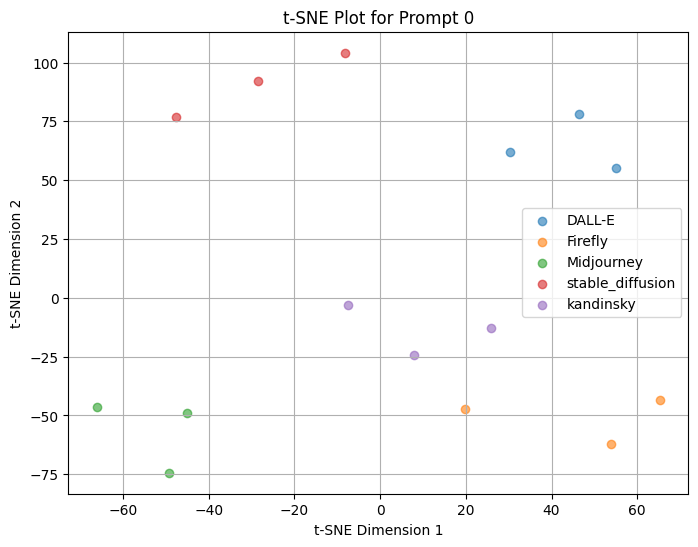

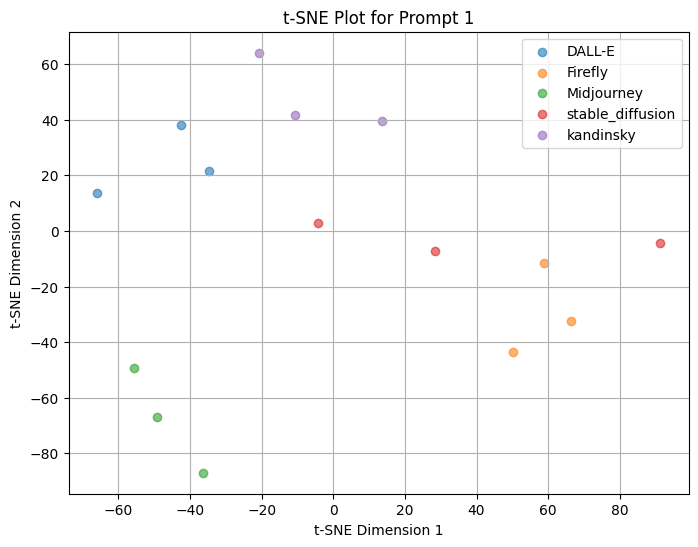

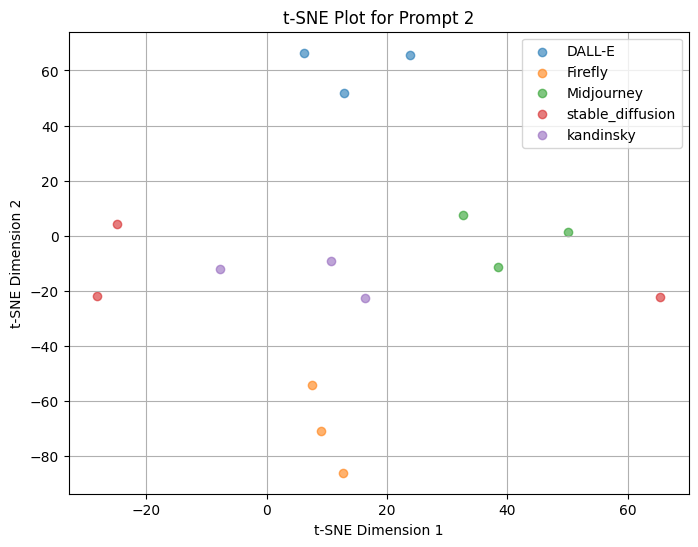

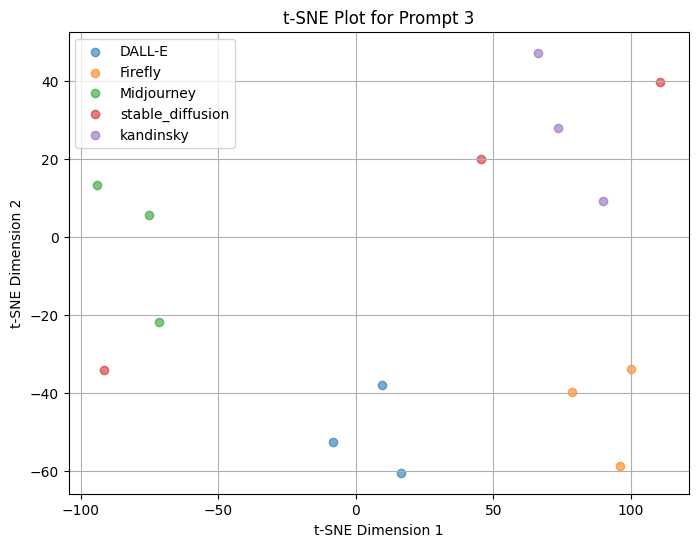

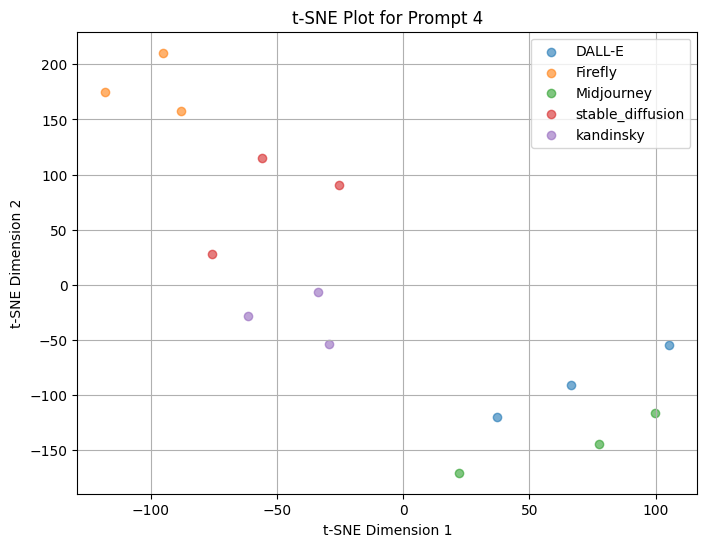

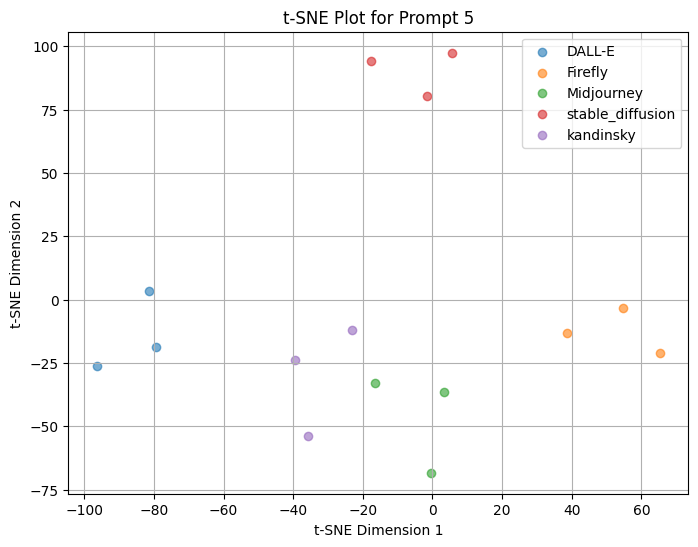

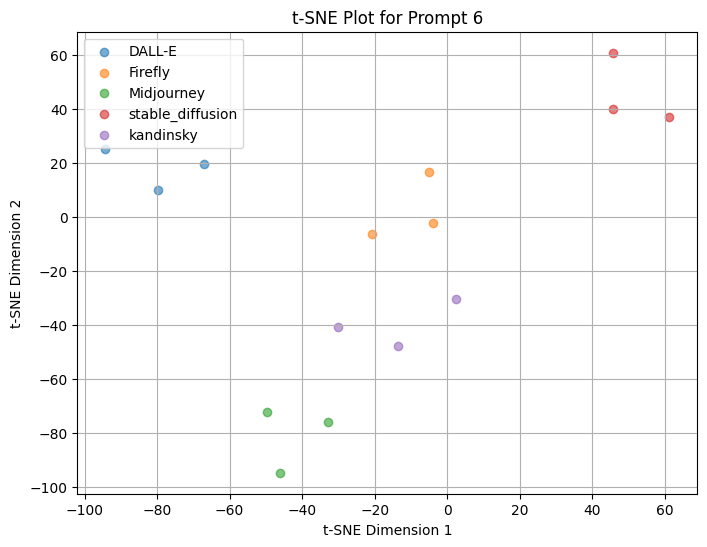

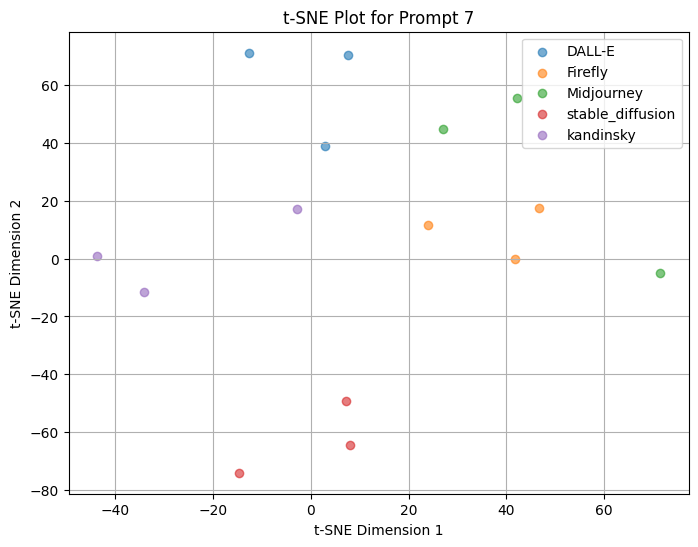

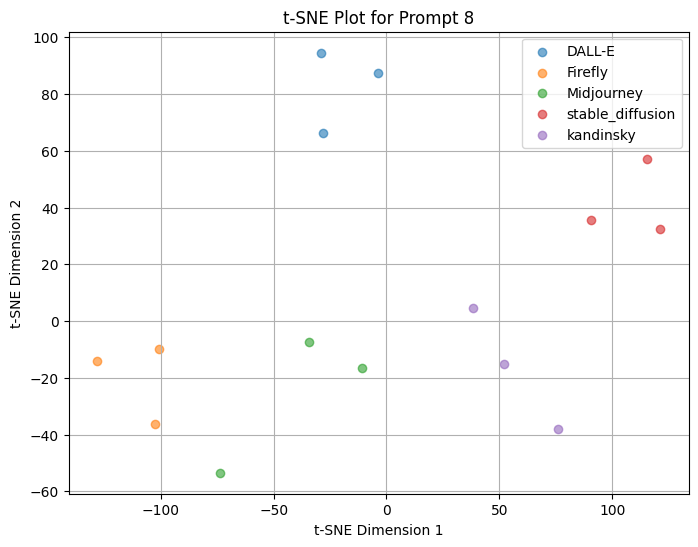

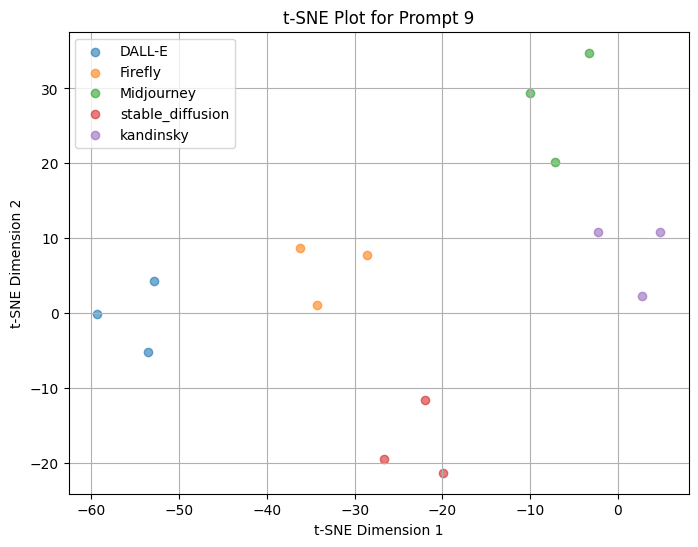

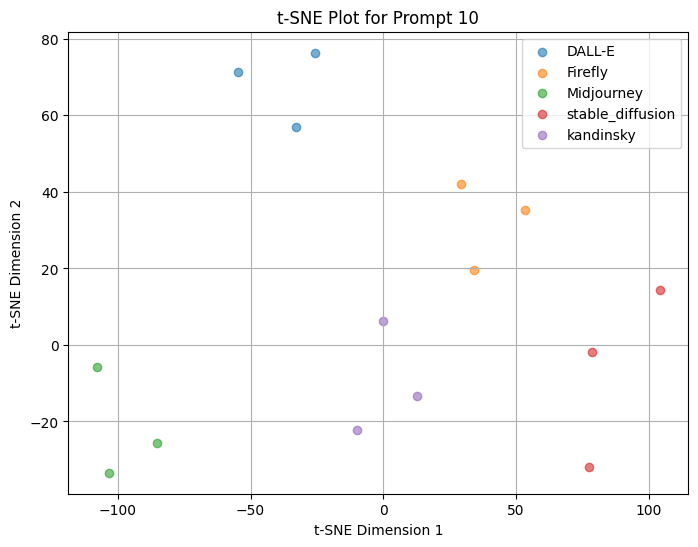

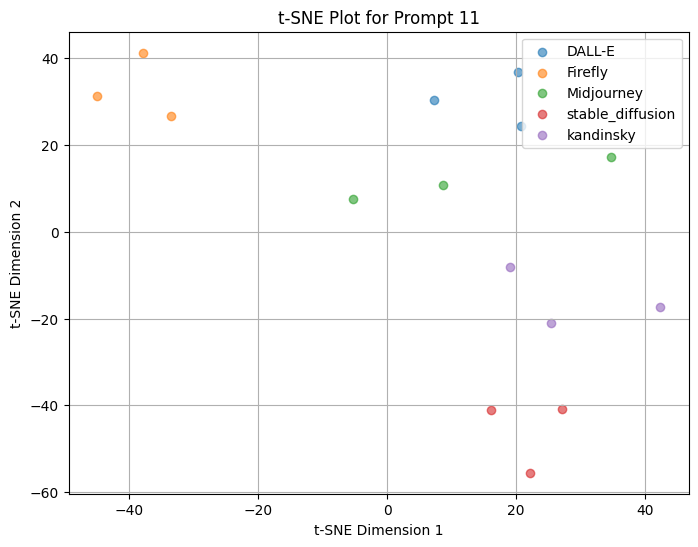

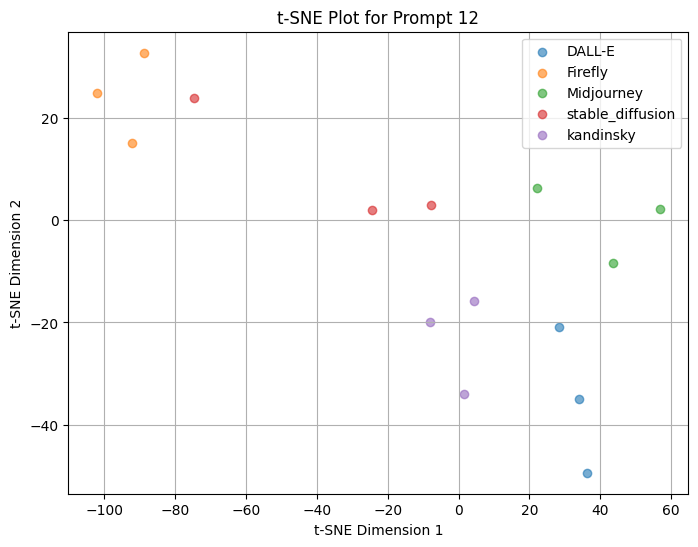

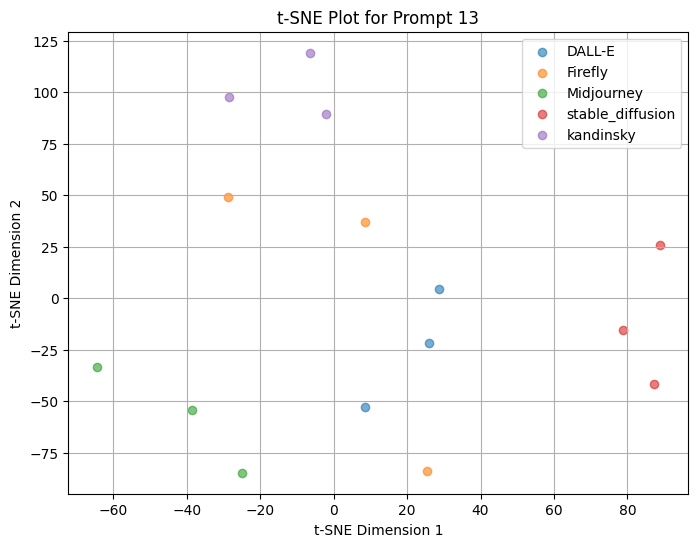

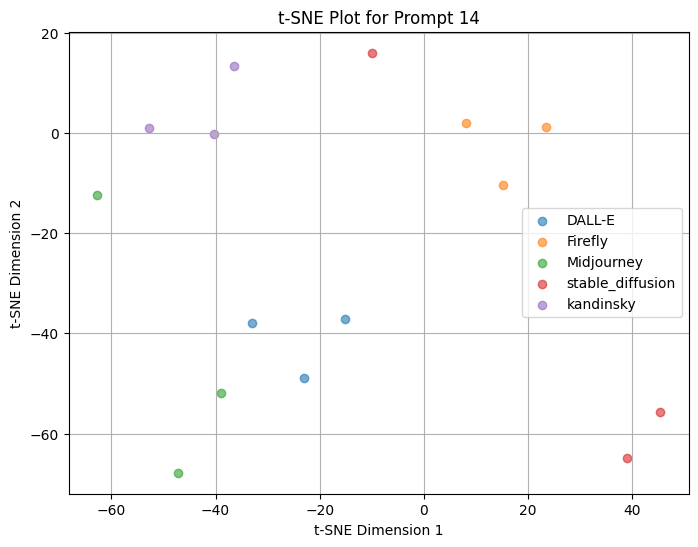

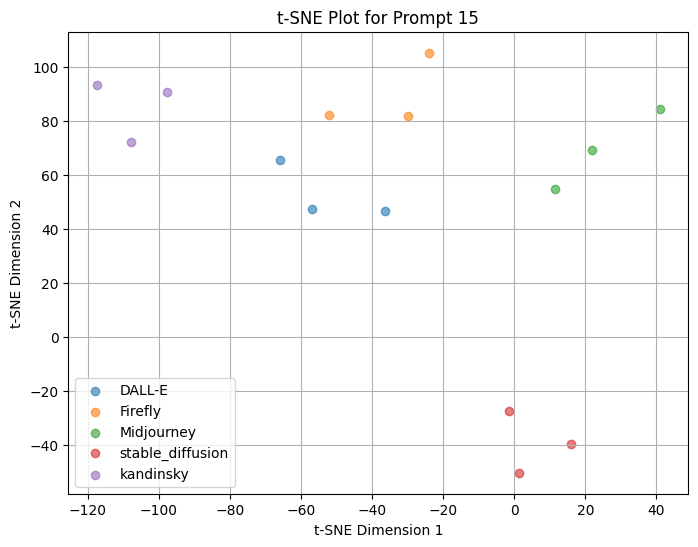

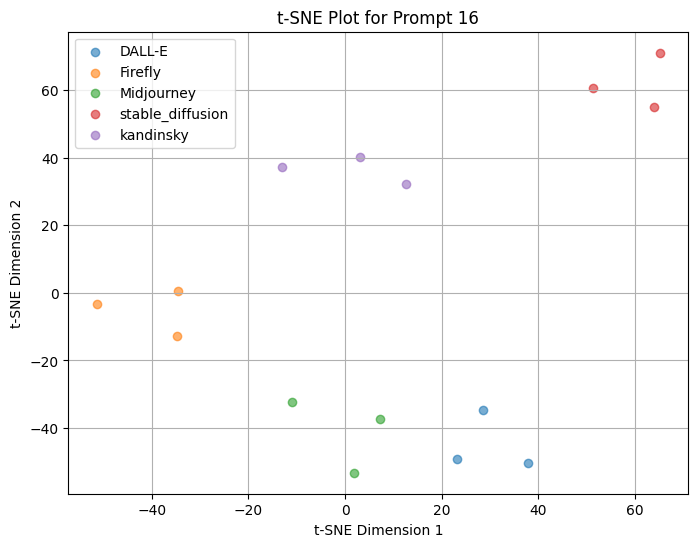

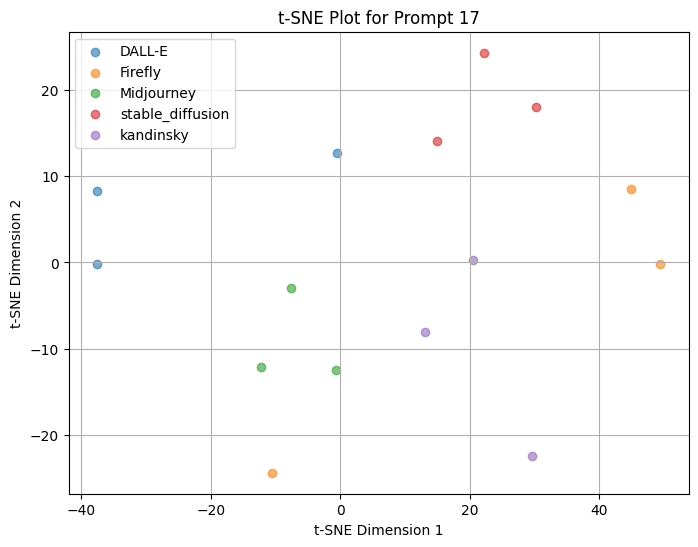

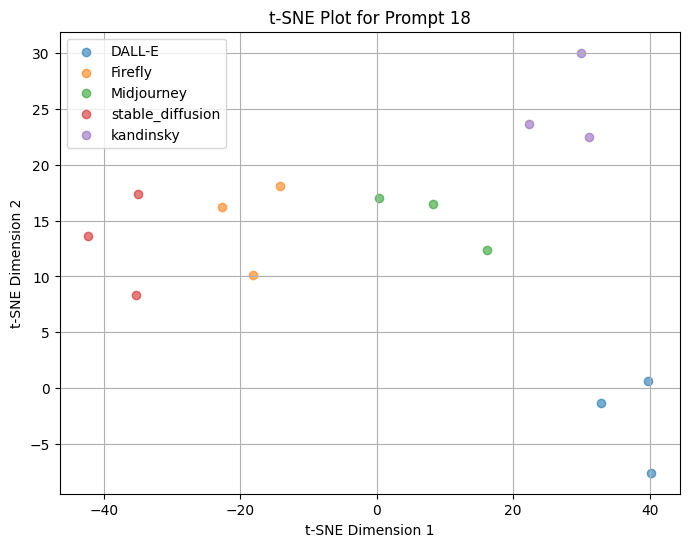

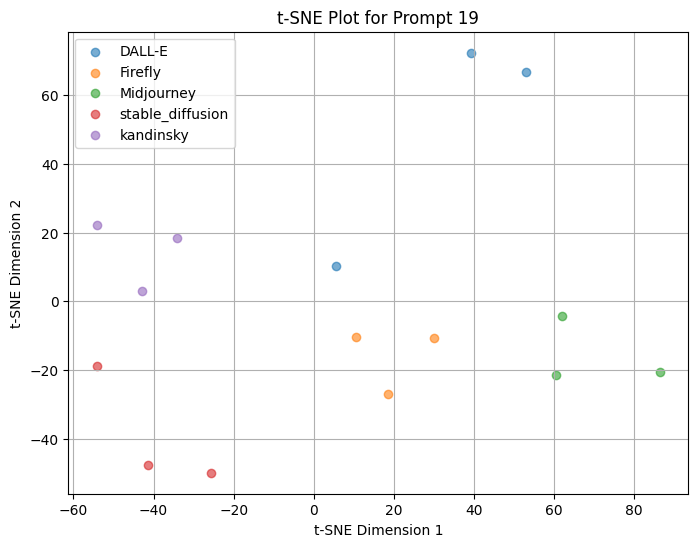

In [105]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

#Loop through all prompt IDs
for prompt_id in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == prompt_id]

    #Run t-SNE on only this prompt's images
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    coords = tsne.fit_transform(group[embedding_cols])

    #Plot
    plt.figure(figsize=(8,6))
    for model in group["model"].unique():
        idx = group["model"] == model
        plt.scatter(coords[idx, 0], coords[idx, 1], label=model, alpha=0.6)
    plt.legend()
    plt.title(f"t-SNE Plot for Prompt {prompt_id}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.show()


In [106]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

#Loop through all prompt IDs
for prompt_id in sorted(df["prompt_id"].unique()):
    print(f"\nPrompt ID: {prompt_id}")

    #Subset images for this prompt
    group = df[df["prompt_id"] == prompt_id]
    pca = PCA(n_components=10, random_state=42)
    embeds_reduced = pca.fit_transform(group[embedding_cols])

    #KMeans clustering
    n_clusters = 3
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeds_reduced)

    group = group.copy()
    group["cluster"] = labels

    #Show number of images per model in each cluster
    cluster_summary = pd.crosstab(group["cluster"], group["model"])
    print(cluster_summary)



Prompt ID: 0
model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             0        2           1          0                 0
1             0        1           2          3                 1
2             3        0           0          0                 2

Prompt ID: 1
model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             0        3           1          0                 1
1             0        0           0          2                 0
2             3        0           2          1                 2

Prompt ID: 2
model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             0        2           0          0                 0
1             0        1           2          3                 3
2             3        0          

In [107]:
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import pairwise_distances
import pandas as pd
import numpy as np

#Initialize dictionary to track total variance per model
model_variance = {model: 0.0 for model in df["model"].unique()}

#Loop through each prompt
for prompt_id in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == prompt_id]

    #PCA reduction to reduce noise in high dimensions
    pca = PCA(n_components=10, random_state=42)
    embeds_reduced = pca.fit_transform(group[embedding_cols])

    group = group.copy()
    group["pca_0"] = embeds_reduced[:, 0]
    group["pca_1"] = embeds_reduced[:, 1]
    group["pca_2"] = embeds_reduced[:, 2]

    #Compute intra-model variance (distance within each model)
    for model in group["model"].unique():
        model_subset = group[group["model"] == model]
        if len(model_subset) > 1:
            coords = model_subset[[f"pca_{i}" for i in range(3)]].values
            dists = pairwise_distances(coords)  #pairwise Euclidean distances
            avg_dist = np.mean(dists[np.triu_indices_from(dists, k=1)])
            model_variance[model] += avg_dist

#Print total variance per model
print("\nTotal Intra-Model Variance Across Prompts")
for model, total_var in sorted(model_variance.items(), key=lambda x: -x[1]):
    print(f"{model}: {total_var:.3f}")



Total Intra-Model Variance Across Prompts
stable_diffusion: 58.202
Midjourney: 46.060
kandinsky: 31.873
DALL-E: 28.431
Firefly: 27.775


In [108]:
mean_embeddings_list = []

for pid in sorted(df["prompt_id"].unique()):
    group = df[df["prompt_id"] == pid]
    means = group.groupby("model")[embedding_cols].mean()
    for model in means.index:
        mean_embeddings_list.append({
            "prompt_id": pid,
            "model": model,
            **dict(zip(embedding_cols, means.loc[model].values))
        })

means_df = pd.DataFrame(mean_embeddings_list)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


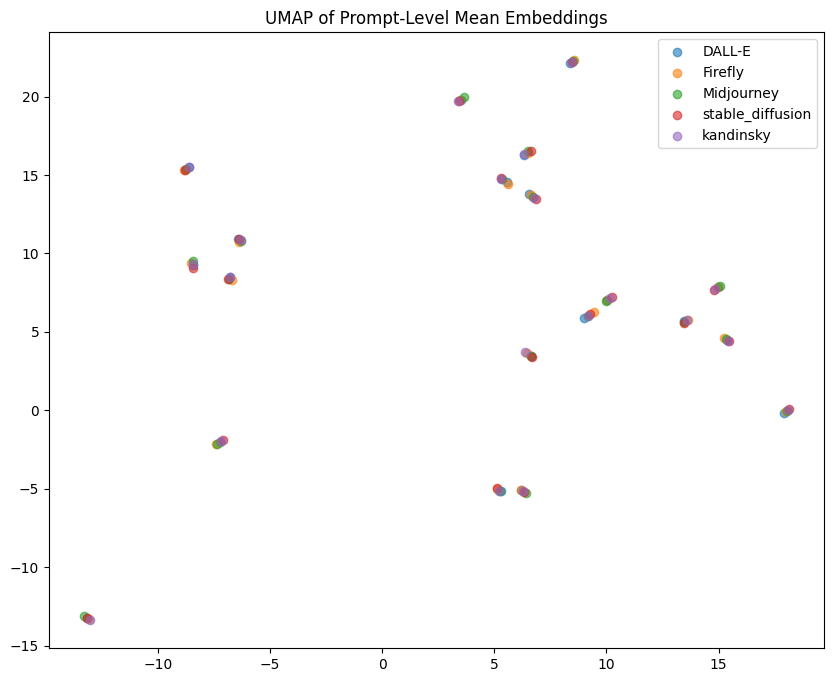

In [109]:
import umap
import matplotlib.pyplot as plt

reducer = umap.UMAP(n_neighbors=5, min_dist=0.1, metric='cosine', random_state=42)

coords = reducer.fit_transform(means_df[embedding_cols])

means_df["x"] = coords[:,0]
means_df["y"] = coords[:,1]

plt.figure(figsize=(10,8))
for model in models:
    idx = means_df["model"] == model
    plt.scatter(means_df.loc[idx,"x"], means_df.loc[idx,"y"], label=model, alpha=0.6)

plt.legend()
plt.title("UMAP of Prompt-Level Mean Embeddings")
plt.show()


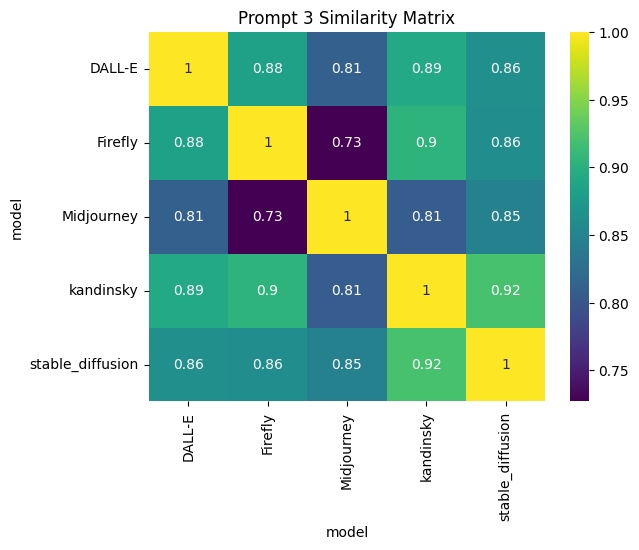

In [110]:
import seaborn as sns

#For one prompt:
pid = 3

group = df[df["prompt_id"] == pid]
means = group.groupby("model")[embedding_cols].mean()
cos_sim = cosine_similarity(means.values)
sim_df = pd.DataFrame(cos_sim, index=means.index, columns=means.index)

sns.heatmap(sim_df, annot=True, cmap="viridis")
plt.title(f"Prompt {pid} Similarity Matrix")
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

#Get unique prompt IDs
prompt_ids = sorted(df["prompt_id"].unique())

for pid in prompt_ids:
    #Subset to images for this prompt
    group = df[df["prompt_id"] == pid]

    #Check how many models exist for this prompt
    models_present = group["model"].unique()

    #Skip if fewer than 2 models have images
    if len(models_present) < 2:
        print(f"Skipping prompt {pid} (only 1 model present)")
        continue

    #Compute mean embeddings for each model
    means = group.groupby("model")[embedding_cols].mean()

    #Compute pairwise cosine similarities
    cos_sim = cosine_similarity(means.values)

    #Format as DataFrame
    sim_df = pd.DataFrame(
        cos_sim,
        index=means.index,
        columns=means.index
    )

    #Plot heatmap
    plt.figure(figsize=(6,5))
    sns.heatmap(sim_df, annot=True, cmap="viridis", fmt=".3f")
    plt.title(f"Prompt {pid} Similarity Matrix")
    plt.show()


In [111]:
from sklearn.metrics.pairwise import cosine_similarity
prompts = [
    "A cat wearing medieval armor standing in a battlefield",
    "A golden retriever playing chess at a table",
    "A frog wearing a spacesuit on the moon",
    "An owl reading a book under a streetlight",
    "A futuristic city skyline with flying cars at sunset",
    "A treehouse built on top of a skyscraper",
    "A mountain range made of glass and crystal",
    "A forest with glowing neon mushrooms",
    "A robot painting a self-portrait in Van Gogh style",
    "A street market scene in watercolor",
    "A steampunk-style train crossing a desert",
    "A jazz band in an abstract Picasso-style painting",
    "A woman exploring an alien jungle on a distant planet",
    "A person floating through a digital cyberspace landscape",
    "An astronaut relaxing on a hammock between two planets",
    "A medieval knight using a laptop in a castle library",
    "A teddy bear having tea with a dragon",
    "A carousel made of candy and gingerbread",
    "A sushi roll flying through outer space",
    "A snowman standing on a beach in the middle of summer"
]
#Load CLIP model
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load("ViT-B/32", device=device)

#Generate text embeddings for all unique prompts
prompt_dict = {}
for pid in df["prompt_id"].unique():
    prompt_text = prompts[pid]
    with torch.no_grad():
        token = clip.tokenize([prompt_text]).to(device)
        text_embed = model_clip.encode_text(token)
        text_embed /= text_embed.norm(dim=-1, keepdim=True)
        prompt_dict[pid] = text_embed.cpu().numpy().flatten()

#Add similarity to DataFrame
similarities = []
for _, row in df.iterrows():
    img_embed = row[embedding_cols].values.reshape(1, -1)
    text_embed = prompt_dict[row["prompt_id"]].reshape(1, -1)
    sim = cosine_similarity(img_embed, text_embed)[0][0]
    similarities.append(sim)

df["image_text_sim"] = similarities


In [ ]:
from itertools import combinations
import numpy as np

trial_consistency = []

for model in df["model"].unique():
  for pid in df["prompt_id"].unique():
    subset = df[(df["model"] == model) & (df["prompt_id"] == pid)]
    embeds = subset[embedding_cols].values
    sims = []
    for i, j in combinations(range(3), 2):
      sim = cosine_similarity([embeds[i]], [embeds[j]])[0][0]
      sims.append(sim)
    avg_sim = np.mean(sims)
    trial_consistency.append({"model": model, "prompt_id": pid, "avg_trial_sim": avg_sim})

consistency_df = pd.DataFrame(trial_consistency)


In [ ]:
#Print the first few rows with image-text similarity
print(df[["filename", "model", "prompt_id", "image_text_sim"]].head())

print("\nTop 10 highest image-text similarity scores:")
print(df.sort_values("image_text_sim", ascending=False)[["filename", "model", "prompt_id", "image_text_sim"]].head(10))

print("\nLowest 10 image-text similarity scores:")
print(df.sort_values("image_text_sim", ascending=True)[["filename", "model", "prompt_id", "image_text_sim"]].head(10))


In [ ]:
#Print all results
print(consistency_df.head())

#Sort by lowest consistency
print("\nLowest consistency examples:")
print(consistency_df.sort_values("avg_trial_sim").head(10))

#Sort by highest consistency
print("\nHighest consistency examples:")
print(consistency_df.sort_values("avg_trial_sim", ascending=False).head(10))

Model Distribution by Cluster:
model    DALL-E  Firefly  Midjourney  kandinsky  stable_diffusion
cluster                                                          
0             3        3           3          3                 3
1             6        6           6          6                 6
2            27       27          24         27                22
3             3        3           3          3                 6
4            21       21          24         21                23

Prompt Distribution by Cluster:
prompt_id  0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  \
cluster                                                                         
0           0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   
1           0   0   0   0   0  15   0   0   0  15   0   0   0   0   0   0   0   
2          15  15  14  15   0   0   0   0  15   0  11  15   0   0   0  15  12   
3           0   0   0   0   0   0   0   0   0   0   0   0   0   0   0

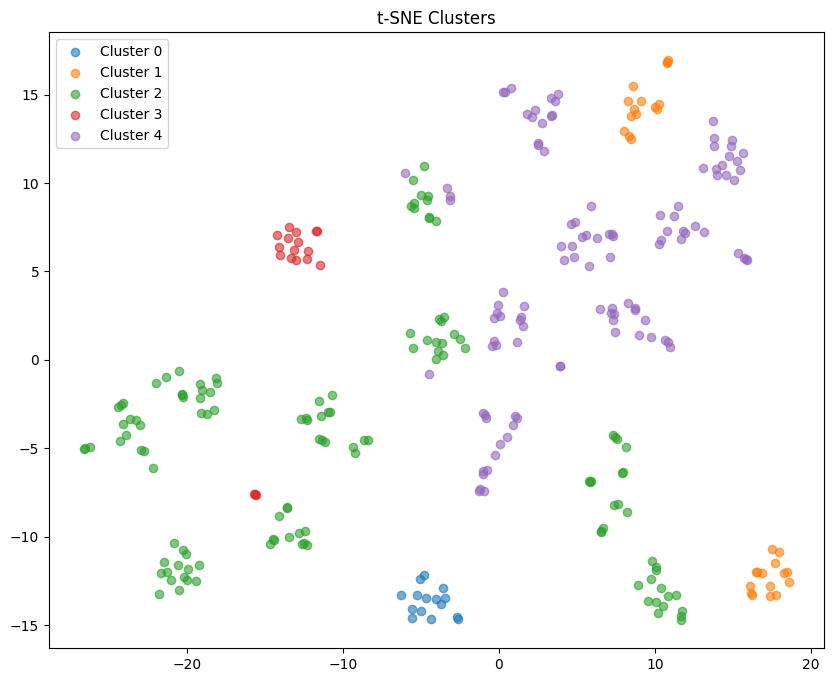

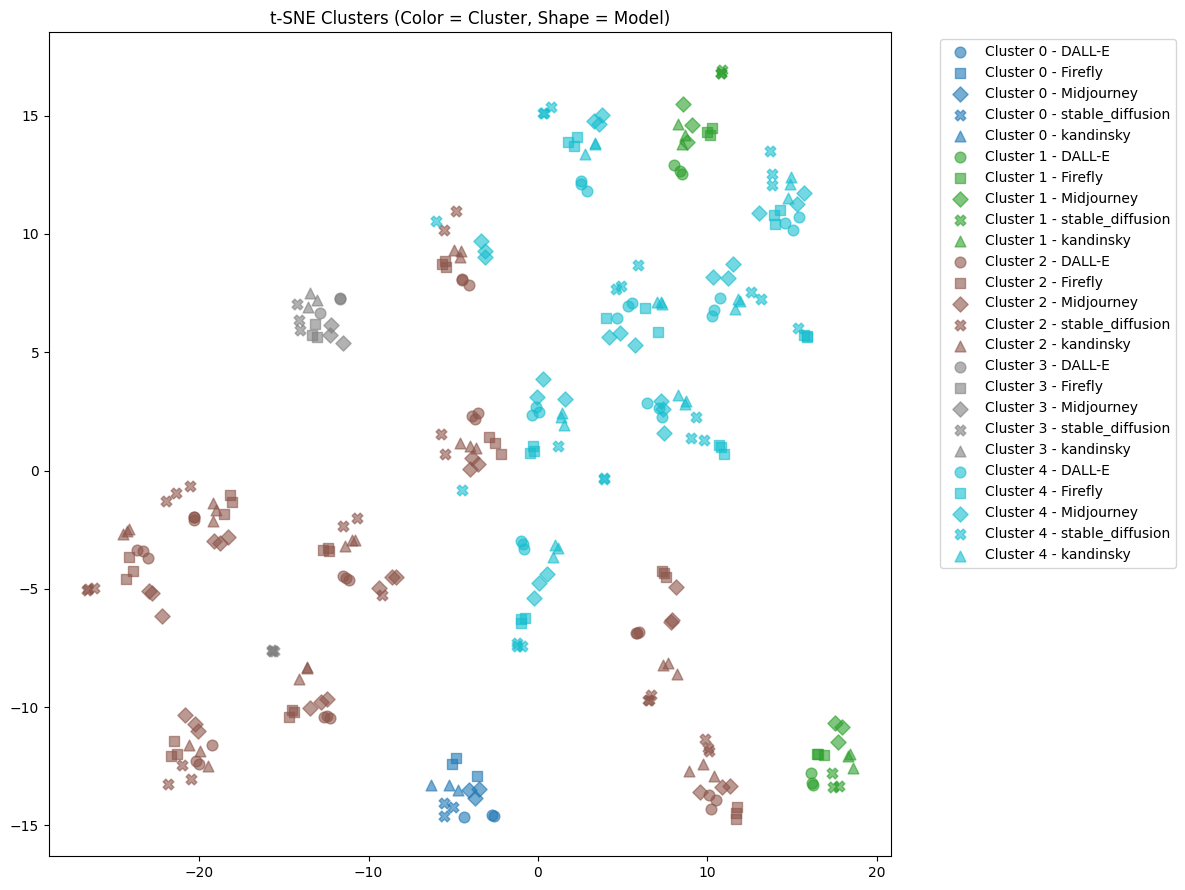

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import numpy as np
import pandas as pd
import os

# Define base directory containing all model folders
base_path = "/content/drive/MyDrive/outputs"

# 1. KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
labels_cluster = kmeans.fit_predict(df[embedding_cols])
df["cluster"] = labels_cluster

# 2. Model Distribution by Cluster
model_dist = pd.crosstab(df["cluster"], df["model"])
print("Model Distribution by Cluster:")
print(model_dist)

# 3. Prompt Distribution by Cluster
prompt_dist = pd.crosstab(df["cluster"], df["prompt_id"])
print("\nPrompt Distribution by Cluster:")
print(prompt_dist)

# 4. Top Prompts by Cluster
for cluster_id in sorted(df["cluster"].unique()):
    prompts_in_cluster = df[df["cluster"] == cluster_id]["prompt_id"]
    top_prompts = Counter(prompts_in_cluster).most_common(3)

    print(f"\nCluster {cluster_id} Top Prompts:")
    for pid, count in top_prompts:
        print(f"Prompt {pid}: '{prompts[pid]}' ({count} images)")

# 5. Visualize Clusters in t-SNE (basic)
plt.figure(figsize=(10, 8))
for c in np.unique(df["cluster"]):
    idx = df["cluster"] == c
    plt.scatter(coords_tsne[idx, 0], coords_tsne[idx, 1], label=f"Cluster {c}", alpha=0.6)
plt.legend()
plt.title("t-SNE Clusters")
plt.show()

# 6. Enhanced t-SNE: Cluster color + Model shape
markers = {
    'DALL-E': 'o',
    'Firefly': 's',
    'Midjourney': 'D',
    'kandinsky': '^',
    'stable_diffusion': 'X'
}

# Get consistent colors for each cluster
cluster_colors = plt.cm.tab10(np.linspace(0, 1, df["cluster"].nunique()))

plt.figure(figsize=(12, 9))
for cluster_id in sorted(df["cluster"].unique()):
    cluster_color = cluster_colors[cluster_id]
    for model in df["model"].unique():
        subset = df[(df["cluster"] == cluster_id) & (df["model"] == model)]
        idx = subset.index
        if len(idx) > 0:
            plt.scatter(
                coords_tsne[idx, 0], coords_tsne[idx, 1],
                label=f"Cluster {cluster_id} - {model}",
                alpha=0.6,
                marker=markers.get(model, 'o'),
                s=60,
                color=cluster_color
            )

plt.title("t-SNE Clusters (Color = Cluster, Shape = Model)")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # remove duplicate labels
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


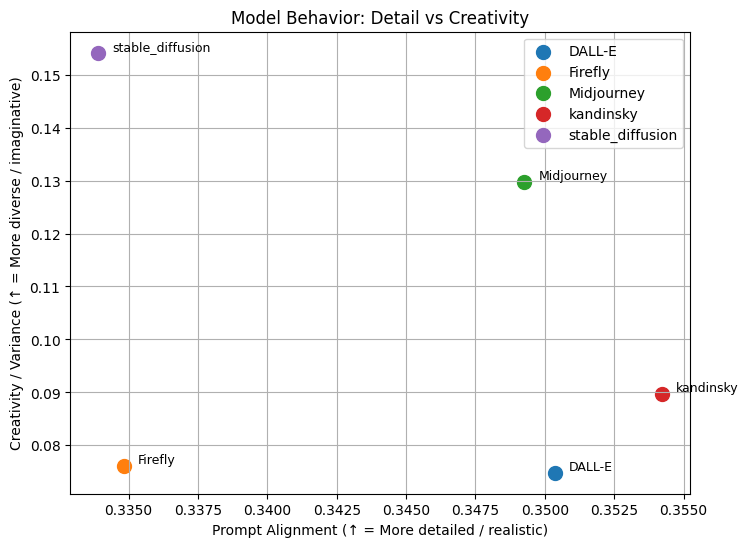

In [113]:
#Step 1: Average image-text similarity per model (Prompt Alignment)
image_text_sim_avg = df.groupby("model")["image_text_sim"].mean()

#Step 2: Average intra-prompt similarity per model (Consistency)
intra_prompt_sim_avg = consistency_df.groupby("model")["avg_trial_sim"].mean()

#Step 3: Combine into model_stats DataFrame
model_stats = pd.DataFrame({
    "avg_image_text_sim": image_text_sim_avg,
    "avg_intra_prompt_sim": intra_prompt_sim_avg
})

#Step 4: Invert intra-prompt similarity to represent Creativity
model_stats["creativity_score"] = 1 - model_stats["avg_intra_prompt_sim"]

#Step 5: Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for model in model_stats.index:
    x = model_stats.loc[model, "avg_image_text_sim"]
    y = model_stats.loc[model, "creativity_score"]
    plt.scatter(x, y, label=model, s=100)
    plt.text(x + 0.0005, y + 0.0005, model, fontsize=9)

plt.xlabel("Prompt Alignment (↑ = More detailed / realistic)")
plt.ylabel("Creativity / Variance (↑ = More diverse / imaginative)")
plt.title("Model Behavior: Detail vs Creativity")
plt.grid(True)
plt.legend()
plt.show()


In [114]:
#Sum CLIP scores (image-text similarity) across all prompts for each model
clip_score_sum = df.groupby("model")["image_text_sim"].sum().sort_values(ascending=False)

#Display the summed scores
print("Total CLIP (image-text) similarity per model:")
print(clip_score_sum)


Total CLIP (image-text) similarity per model:
model
kandinsky           21.253075
DALL-E              21.022146
Midjourney          20.955767
Firefly             20.090251
stable_diffusion    20.034727
Name: image_text_sim, dtype: float64


model
Firefly             63.611191
stable_diffusion    61.407846
DALL-E              58.230983
kandinsky           52.788292
Midjourney          34.696215
Name: colorfulness, dtype: float64


<Axes: title={'center': 'Average Colorfulness per Model'}, xlabel='model', ylabel='Colorfulness Score'>

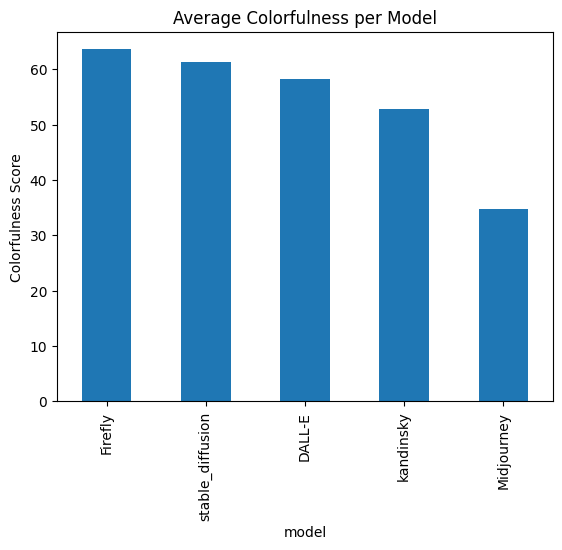

In [115]:
import cv2
import numpy as np
from PIL import Image
from pathlib import Path
base_path = "/content/drive/MyDrive/CS6365/outputs"

#Strip spaces and construct the full path
df["filepath"] = df.apply(
    lambda row: os.path.join(base_path, row["model"].strip(), row["filename"].strip()), axis=1
)
df = df[df["filepath"].apply(lambda p: Path(p).exists())]
df["colorfulness"] = df["filepath"].apply(calculate_colorfulness)

def calculate_colorfulness(image_path):
    image = np.array(Image.open(image_path).convert('RGB'))
    (B, G, R) = cv2.split(image.astype("float"))

    rg = np.absolute(R - G)
    yb = np.absolute(0.5 * (R + G) - B)

    std_rg, mean_rg = np.std(rg), np.mean(rg)
    std_yb, mean_yb = np.std(yb), np.mean(yb)

    #Colorfulness formula
    colorfulness = np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)
    return colorfulness
df["colorfulness"] = df["filepath"].apply(calculate_colorfulness)
model_colorfulness = df.groupby("model")["colorfulness"].mean().sort_values(ascending=False)
print(model_colorfulness)
model_colorfulness.plot(kind="bar", title="Average Colorfulness per Model", ylabel="Colorfulness Score")
